In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import time

# Downloading the dataset for trainee

In [18]:
df_1 = pd.read_csv("checkin_checkout_history_updated.csv")
display(df_1.head(3))
df_2 = pd.read_csv("gym_locations_data.csv")
display(df_2.head(3))
df_3 = pd.read_csv("subscription_plans.csv")
display(df_3.head(3))
df_4 = pd.read_csv("users_data.csv")
display(df_4.head(3))
table_1 = df_1.merge(df_2, right_on="gym_id", left_on="gym_id")
table_2 = df_4.merge(df_3, right_on="subscription_plan", left_on="subscription_plan")
data = table_1.merge(table_2, right_on="user_id", left_on="user_id")

,user_id,gym_id,checkin_time,checkout_time,workout_type,calories_burned
0,user_3291,gym_6,2023-09-10 15:55:00,2023-09-10 16:34:00,Weightlifting,462
1,user_1944,gym_2,2023-04-13 20:07:00,2023-04-13 22:43:00,Yoga,1278
2,user_958,gym_7,2023-06-10 12:24:00,2023-06-10 13:49:00,Cardio,858


,gym_id,location,gym_type,facilities
0,gym_1,New York,Premium,"Climbing Wall, Swimming Pool, Basketball Court"
1,gym_2,Los Angeles,Budget,"Climbing Wall, Yoga Classes, Sauna"
2,gym_3,Chicago,Budget,"Sauna, Climbing Wall, Swimming Pool"


,subscription_plan,price_per_month,features
0,Basic,19.99,"Access to basic gym facilities, Limited class ..."
1,Pro,49.99,"Access to all facilities, Unlimited class acce..."
2,Student,9.99,"Access to basic facilities, Limited class acce..."


,user_id,first_name,last_name,age,gender,birthdate,sign_up_date,user_location,subscription_plan
0,user_1,Chris,Wilson,56,Female,2000-02-29,2023-02-06,Denver,Basic
1,user_2,Michael,Miller,46,Non-binary,1978-12-22,2023-08-08,Orlando,Pro
2,user_3,Daniel,Smith,32,Female,1962-08-30,2021-01-11,Orlando,Basic


In [19]:
display(data.head(3))
data.shape

,user_id,gym_id,checkin_time,checkout_time,workout_type,calories_burned,location,gym_type,facilities,first_name,last_name,age,gender,birthdate,sign_up_date,user_location,subscription_plan,price_per_month,features
0,user_3291,gym_6,2023-09-10 15:55:00,2023-09-10 16:34:00,Weightlifting,462,Philadelphia,Budget,"Swimming Pool, Climbing Wall, Sauna",Michael,Rodriguez,41,Female,1998-03-10,2023-04-08,Atlanta,Pro,49.99,"Access to all facilities, Unlimited class acce..."
1,user_3291,gym_6,2023-09-09 08:12:00,2023-09-09 09:55:00,Weightlifting,850,Philadelphia,Budget,"Swimming Pool, Climbing Wall, Sauna",Michael,Rodriguez,41,Female,1998-03-10,2023-04-08,Atlanta,Pro,49.99,"Access to all facilities, Unlimited class acce..."
2,user_3291,gym_6,2023-07-23 19:58:00,2023-07-23 22:12:00,Cardio,1089,Philadelphia,Budget,"Swimming Pool, Climbing Wall, Sauna",Michael,Rodriguez,41,Female,1998-03-10,2023-04-08,Atlanta,Pro,49.99,"Access to all facilities, Unlimited class acce..."


(300000, 19)

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            300000 non-null  object 
 1   gym_id             300000 non-null  object 
 2   checkin_time       300000 non-null  object 
 3   checkout_time      300000 non-null  object 
 4   workout_type       300000 non-null  object 
 5   calories_burned    300000 non-null  int64  
 6   location           300000 non-null  object 
 7   gym_type           300000 non-null  object 
 8   facilities         300000 non-null  object 
 9   first_name         300000 non-null  object 
 10  last_name          300000 non-null  object 
 11  age                300000 non-null  int64  
 12  gender             300000 non-null  object 
 13  birthdate          300000 non-null  object 
 14  sign_up_date       300000 non-null  object 
 15  user_location      300000 non-null  object 
 16  su

In [21]:
data = data.iloc[:10000, :].copy()

In [22]:
data['gym_id'].value_counts()

gym_6     1161
gym_3     1018
gym_7     1005
gym_9     1002
gym_2      991
gym_4      982
gym_10     972
gym_8      971
gym_1      953
gym_5      945
Name: gym_id, dtype: int64

In [32]:
gym_counts = data['gym_id'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=gym_counts.index, y=gym_counts.values, palette='viridis')

plt.title('Количество записей для каждого gym_id', fontsize=16)
plt.xlabel('Gym ID', fontsize=14)
plt.ylabel('Количество', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

NameError: name 'sns' is not defined

<Figure size 1000x600 with 0 Axes>

In [23]:
data.isna().sum(axis=0)

user_id              0
gym_id               0
checkin_time         0
checkout_time        0
workout_type         0
calories_burned      0
location             0
gym_type             0
facilities           0
first_name           0
last_name            0
age                  0
gender               0
birthdate            0
sign_up_date         0
user_location        0
subscription_plan    0
price_per_month      0
features             0
dtype: int64

In [24]:
for column in data.columns:
    print(column)
    print(data[column].nunique())
    print("------------------------------")

user_id
164
------------------------------
gym_id
10
------------------------------
checkin_time
9822
------------------------------
checkout_time
9817
------------------------------
workout_type
6
------------------------------
calories_burned
1773
------------------------------
location
10
------------------------------
gym_type
3
------------------------------
facilities
10
------------------------------
first_name
12
------------------------------
last_name
12
------------------------------
age
47
------------------------------
gender
3
------------------------------
birthdate
162
------------------------------
sign_up_date
153
------------------------------
user_location
10
------------------------------
subscription_plan
3
------------------------------
price_per_month
3
------------------------------
features
3
------------------------------


In [38]:
class BoostingFocalLossClassifier:
    def __init__(self, n_estimators=50, max_depth=10, learning_rate=0.1, gamma=2, early_stopping_rounds=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.early_stopping_rounds = early_stopping_rounds
        self.trees = []
        self.best_iteration = 0
        self.best_accuracy = 0.0
        self.no_improve_count = 0

    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_classes = X.shape[0], len(np.unique(y))
        self.classes_ = np.unique(y)
        y_pred = np.zeros((n_samples, n_classes), dtype=np.float64)  # Начальные предсказания в виде логитов
        val_accuracies = []

        for t in range(self.n_estimators):
            # Преобразование y_pred в вероятности с помощью softmax
            probs = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
            
            # One-hot кодирование y
            one_hot_y = np.eye(n_classes)[y]

            # Вычисляем ошибки (residuals)
            residuals = one_hot_y - probs

            # Вычисление градиента с учетом фокального лосса
            gradient = (self.gamma * residuals * (1 - probs) ** (self.gamma - 1)) * probs

            # Используем градиент в качестве мишени для обучения
            # Градиенты будем передавать как целевые значения для дерева
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features="sqrt")
            tree.fit(X, np.argmax(gradient, axis=1))  # Используем градиенты для обучения
            self.trees.append(tree)

            # Обновление предсказаний
            y_pred += self.learning_rate * tree.predict_proba(X)

            # Оценка на валидационной выборке
            if X_val is not None and y_val is not None:
                y_val_pred = self.predict(X_val)
                current_accuracy = accuracy_score(y_val, y_val_pred)
                val_accuracies.append(current_accuracy)

                # print(f"Iteration {t + 1}: Validation Accuracy = {current_accuracy:.4f}")

                if current_accuracy > self.best_accuracy:
                    self.best_accuracy = current_accuracy
                    self.best_iteration = t + 1
                    self.no_improve_count = 0
                else:
                    self.no_improve_count += 1

                if self.no_improve_count >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {t + 1}. Best iteration: {self.best_iteration} with Accuracy = {self.best_accuracy:.4f}")
                    break

        return val_accuracies

    def predict(self, X):
        # Суммируем предсказания всех деревьев
        y_pred = np.zeros((X.shape[0], len(self.classes_)), dtype=np.float64)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict_proba(X)

        # Преобразуем в вероятности и выбираем класс с максимальной вероятностью
        return np.argmax(y_pred, axis=1)

Testing combination: n_estimators=50, learning_rate=0.01, gamma=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 31. Best iteration: 23 with Accuracy = 0.9994
Testing combination: n_estimators=50, learning_rate=0.01, gamma=1.5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 43. Best iteration: 35 with Accuracy = 0.9981
Testing combination: n_estimators=50, learning_rate=0.1, gamma=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 15. Best iteration: 7 with Accuracy = 0.9706
Testing combination: n_estimators=50, learning_rate=0.1, gamma=1.5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 35. Best iteration: 27 with Accuracy = 0.9994
Testing combination: n_estimators=300, learning_rate=0.01, gamma=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 36. Best iteration: 28 with Accuracy = 0.9994
Testing combination: n_estimators=300, learning_rate=0.01, gamma=1.5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 41. Best iteration: 33 with Accuracy = 1.0000
Testing combination: n_estimators=300, learning_rate=0.1, gamma=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 28. Best iteration: 20 with Accuracy = 0.9975
Testing combination: n_estimators=300, learning_rate=0.1, gamma=1.5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 18. Best iteration: 10 with Accuracy = 0.9219
Testing combination: n_estimators=500, learning_rate=0.01, gamma=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 24. Best iteration: 16 with Accuracy = 0.9994
Testing combination: n_estimators=500, learning_rate=0.01, gamma=1.5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 26. Best iteration: 18 with Accuracy = 0.9994
Testing combination: n_estimators=500, learning_rate=0.1, gamma=1.0


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 67. Best iteration: 59 with Accuracy = 0.9988
Testing combination: n_estimators=500, learning_rate=0.1, gamma=1.5


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Early stopping at iteration 38. Best iteration: 30 with Accuracy = 1.0000

Grid Search Results:
    n_estimators  learning_rate  ...  best_val_accuracy  test_accuracy
5            300           0.01  ...           1.000000         1.0000
11           500           0.10  ...           1.000000         1.0000
0             50           0.01  ...           0.999375         0.9995
3             50           0.10  ...           0.999375         0.9995
4            300           0.01  ...           0.999375         0.9995
9            500           0.01  ...           0.999375         0.9995
8            500           0.01  ...           0.999375         0.9980
10           500           0.10  ...           0.998750         0.9975
1             50           0.01  ...           0.998125         0.9970
6            300           0.10  ...           0.997500         0.9945
2             50           0.10  ...           0.970625         0.9280
7            300           0.10  ...           0.921

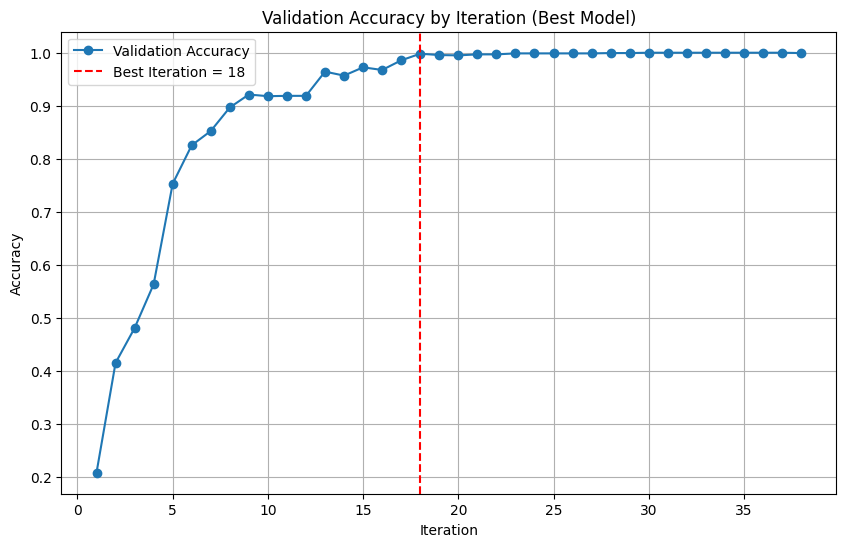

In [39]:
from itertools import product
import pandas as pd

# Определяем параметры для гридсерча
param_grid = {
    'n_estimators': [50, 300, 500],
    'learning_rate': [0.01, 0.1],
    'gamma': [1.0, 1.5]
}

# Получаем все комбинации параметров
param_combinations = list(product(param_grid['n_estimators'], param_grid['learning_rate'], param_grid['gamma']))

# Результаты будем хранить в списке
results = []

for n_estimators, learning_rate, gamma in param_combinations:
    print(f"Testing combination: n_estimators={n_estimators}, learning_rate={learning_rate}, gamma={gamma}")

    # Инициализируем модель с текущими параметрами
    model = BoostingFocalLossClassifier(
        n_estimators=n_estimators, 
        max_depth=10, 
        learning_rate=learning_rate, 
        gamma=gamma, 
        early_stopping_rounds=8
    )

    # Преобразуем данные
    X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train_inner)
    X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
    X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

    # Обучаем модель
    val_accuracies = model.fit(X_train_transformed, y_train_inner, X_val_transformed, y_val)

    # Предсказываем на тестовой выборке
    y_pred = model.predict(X_test_transformed)
    test_accuracy = accuracy_score(y_test, y_pred)

    # Сохраняем результаты
    results.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'gamma': gamma,
        'best_iteration': model.best_iteration,
        'best_val_accuracy': model.best_accuracy,
        'test_accuracy': test_accuracy
    })

# Конвертируем результаты в DataFrame для удобства анализа
results_df = pd.DataFrame(results)

# Сортируем по наилучшей тестовой точности
sorted_results = results_df.sort_values(by='test_accuracy', ascending=False)
print("\nGrid Search Results:")
print(sorted_results)

# Выводим лучшие параметры
best_params = sorted_results.iloc[0]
print("\nBest Parameters:")
print(best_params)

# Построение графика валидационной точности для лучшей модели
best_model = BoostingFocalLossClassifier(
    n_estimators=int(best_params['n_estimators']),
    max_depth=10,
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    early_stopping_rounds=8
)

best_model.fit(X_train_transformed, y_train_inner, X_val_transformed, y_val)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
plt.axvline(best_model.best_iteration, color='r', linestyle='--', label=f'Best Iteration = {best_model.best_iteration}')
plt.title("Validation Accuracy by Iteration (Best Model)")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

In [40]:
class BoostingFocalLossClassifier:
    def __init__(self, n_estimators=300, max_depth=10, learning_rate=0.1, gamma=2, early_stopping_rounds=5):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.early_stopping_rounds = early_stopping_rounds
        self.trees = []
        self.best_iteration = 0
        self.best_accuracy = 0.0
        self.no_improve_count = 0

    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_classes = X.shape[0], len(np.unique(y))
        self.classes_ = np.unique(y)
        y_pred = np.zeros((n_samples, n_classes), dtype=np.float64)  # Начальные предсказания в виде логитов
        val_accuracies = []

        for t in range(self.n_estimators):
            # Преобразование y_pred в вероятности с помощью softmax
            probs = np.exp(y_pred) / np.sum(np.exp(y_pred), axis=1, keepdims=True)
            
            # One-hot кодирование y
            one_hot_y = np.eye(n_classes)[y]

            # Вычисляем ошибки (residuals)
            residuals = one_hot_y - probs

            # Вычисление градиента с учетом фокального лосса
            gradient = (self.gamma * residuals * (1 - probs) ** (self.gamma - 1)) * probs

            # Используем градиент в качестве мишени для обучения
            # Градиенты будем передавать как целевые значения для дерева
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features="sqrt")
            tree.fit(X, np.argmax(gradient, axis=1))  # Используем градиенты для обучения
            self.trees.append(tree)

            # Обновление предсказаний
            y_pred += self.learning_rate * tree.predict_proba(X)

            # Оценка на валидационной выборке
            if X_val is not None and y_val is not None:
                y_val_pred = self.predict(X_val)
                current_accuracy = accuracy_score(y_val, y_val_pred)
                val_accuracies.append(current_accuracy)

                print(f"Iteration {t + 1}: Validation Accuracy = {current_accuracy:.4f}")

                if current_accuracy > self.best_accuracy:
                    self.best_accuracy = current_accuracy
                    self.best_iteration = t + 1
                    self.no_improve_count = 0
                else:
                    self.no_improve_count += 1

                if self.no_improve_count >= self.early_stopping_rounds:
                    print(f"Early stopping at iteration {t + 1}. Best iteration: {self.best_iteration} with Accuracy = {self.best_accuracy:.4f}")
                    break

        return val_accuracies

    def predict(self, X):
        # Суммируем предсказания всех деревьев
        y_pred = np.zeros((X.shape[0], len(self.classes_)), dtype=np.float64)
        for tree in self.trees:
            y_pred += self.learning_rate * tree.predict_proba(X)

        # Преобразуем в вероятности и выбираем класс с максимальной вероятностью
        return np.argmax(y_pred, axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Iteration 1: Validation Accuracy = 0.2194
Iteration 2: Validation Accuracy = 0.3894
Iteration 3: Validation Accuracy = 0.5062
Iteration 4: Validation Accuracy = 0.5125
Iteration 5: Validation Accuracy = 0.6225
Iteration 6: Validation Accuracy = 0.6256
Iteration 7: Validation Accuracy = 0.7031
Iteration 8: Validation Accuracy = 0.7913
Iteration 9: Validation Accuracy = 0.8675
Iteration 10: Validation Accuracy = 0.8838
Iteration 11: Validation Accuracy = 0.8831
Iteration 12: Validation Accuracy = 0.8844
Iteration 13: Validation Accuracy = 0.9069
Iteration 14: Validation Accuracy = 0.9106
Iteration 15: Validation Accuracy = 0.9194
Iteration 16: Validation Accuracy = 0.9169
Iteration 17: Validation Accuracy = 0.9169
Iteration 18: Validation Accuracy = 0.9487
Iteration 19: Validation Accuracy = 0.9531
Iteration 20: Validation Accuracy = 0.9437
Iteration 21: Validation Accuracy = 0.9413
Iteration 22: Validation Accuracy = 1.0000
Iteration 23: Validation Accuracy = 0.9994
Iteration 24: Valida

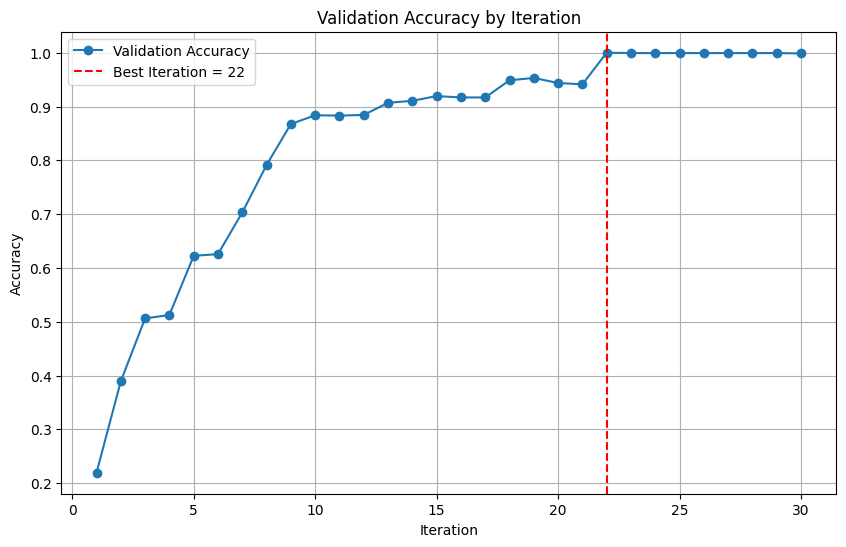

Total execution time: 0.57 minutes


In [45]:
# Подготовка данных
start_time = time.time()

X = data.drop(columns='gym_id')
y = data['gym_id'].astype('category').cat.codes

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_inner, X_val, y_train_inner, y_val = train_test_split(X_train, y_train, test_size=0.2)

preprocessor = ColumnTransformer(
    transformers=[ 
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[ 
    ('preprocessor', preprocessor),
    ('model', BoostingFocalLossClassifier(n_estimators=300, max_depth=10, learning_rate=0.01, gamma=1.5, early_stopping_rounds=8))
])

model = pipeline.named_steps['model']
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train_inner)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

val_accuracies = model.fit(X_train_transformed, y_train_inner, X_val_transformed, y_val)

y_pred = model.predict(X_test_transformed)
test_accuracy = accuracy_score(y_test, y_pred)

print("Final Test Accuracy:", test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='o', label="Validation Accuracy")
plt.axvline(model.best_iteration, color='r', linestyle='--', label=f'Best Iteration = {model.best_iteration}')
plt.title("Validation Accuracy by Iteration")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Total execution time: {elapsed_time:.2f} minutes")

In [14]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

start_time = time.time()

# Prepare data
X = data.drop(columns='gym_id')
y = data['gym_id'].astype('category').cat.codes

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_inner, X_val, y_train_inner, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[ 
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Define pipeline with XGBClassifier
pipeline = Pipeline(steps=[ 
    ('preprocessor', preprocessor),
    ('model', xgb.XGBClassifier(n_estimators=300, max_depth=10, learning_rate=0.01, gamma=1.5, early_stopping_rounds=8, objective='multi:softmax'))
])

# Fit the model
model = pipeline.named_steps['model']
X_train_transformed = pipeline.named_steps['preprocessor'].fit_transform(X_train_inner)
X_val_transformed = pipeline.named_steps['preprocessor'].transform(X_val)
X_test_transformed = pipeline.named_steps['preprocessor'].transform(X_test)

model.fit(X_train_transformed, y_train_inner, eval_set=[(X_val_transformed, y_val)], verbose=10)

# Make predictions
y_pred = model.predict(X_test_transformed)
test_accuracy = accuracy_score(y_test, y_pred)

print("Final Test Accuracy:", test_accuracy)

end_time = time.time()
elapsed_time = (end_time - start_time)/60
print(f"Total execution time: {elapsed_time:.2f} minutes")

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [1, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[0]	validation_0-mlogloss:2.25312
[10]	validation_0-mlogloss:1.86200
[20]	validation_0-mlogloss:1.58567
[30]	validation_0-mlogloss:1.37345
[40]	validation_0-mlogloss:1.20257
[50]	validation_0-mlogloss:1.06080
[60]	validation_0-mlogloss:0.94076
[70]	validation_0-mlogloss:0.83762
[80]	validation_0-mlogloss:0.74806
[90]	validation_0-mlogloss:0.66966
[100]	validation_0-mlogloss:0.60059
[110]	validation_0-mlogloss:0.53945
[120]	validation_0-mlogloss:0.48513
[130]	validation_0-mlogloss:0.43671
[140]	validation_0-mlogloss:0.39345
[150]	validation_0-mlogloss:0.35472
[160]	validation_0-mlogloss:0.31998
[170]	validation_0-mlogloss:0.28879
[180]	validation_0-mlogloss:0.26074
[190]	validation_0-mlogloss:0.23551
[200]	validation_0-mlogloss:0.21278
[210]	validation_0-mlogloss:0.19230
[220]	validation_0-mlogloss:0.17384
[230]	validation_0-mlogloss:0.15718
[240]	validation_0-mlogloss:0.14215
[250]	validation_0-mlogloss:0.12858
[260]	validation_0-mlogloss:0.11632
[270]	validation_0-mlogloss:0.10525
[28